In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import sys; sys.path.insert(0, os.path.abspath("../"))
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List
from dataset.dataset import SkinLesion_Dataset, SegExamples
from pipeline.preprocessing import SkinLesionPreprocessing
from pipeline.feature_extraction import FeaturesExtraction

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, cohen_kappa_score, make_scorer
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as impipe

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.utils import class_weight
from joblib import dump, load

from scipy import stats


In [3]:
def majority_voting_ensemble(classifiers: dict, X: np.ndarray, y_true: np.ndarray, weights: List, return_predicted = False):
    """
    Obtain majority voting results from a dictionary of classifiers. 
    Computes hard voting, soft voting and weighted soft voting

    Args:
        classifiers (dict): Dictionary containing each classifier in the ensemble. ('clf_name': clf)
        X (np.ndarray): Feature space. Shape samples X features
        y_true (np.ndarray): True labels. Shape samples
        weights (List): List of weights for weighted soft voting. In order of appearance in the dict of clfs.
        return_predicted (bool, optional): If True, returns also the predicted labels for each voting. 
        Defaults to False.

    Returns:
        _type_: _description_
    """
    voting_results = {}
    weights = np.asarray(weights)

    # Hard
    hard_results = {}
    results_hard = np.zeros((y_true.shape[0],len(classifiers)))
    soft_results = {}
    results_soft = np.zeros((y_true.shape[0],3,len(classifiers)))
    soft_w_results = {}
    # results_w = np.zeros((y_true.shape[0],3,len(classifiers)))

    for i, clf in enumerate(classifiers.values()): 
        results_hard[:,i] = clf.predict(X)
        results_soft[:,:,i] = clf.predict_proba(X)
    results_w = results_soft*np.tile(np.array(weights), (results_soft.shape[0], 1))[:, np.newaxis]

    y_pred_hard, _ = np.uint16(stats.mode(results_hard, axis=1, keepdims=False))
    hard_results['kappa'] = cohen_kappa_score(y_true, y_pred_hard)
    hard_results['cm'] = confusion_matrix(y_true, y_pred_hard)
    voting_results['hard'] = hard_results

    y_pred_soft = np.argmax(np.mean(results_soft, axis=2), axis=1)
    soft_results['kappa'] = cohen_kappa_score(y_true, y_pred_soft)
    soft_results['cm'] = confusion_matrix(y_true, y_pred_soft)
    voting_results['soft'] = soft_results

    y_pred_soft_w = np.argmax(np.mean(results_w, axis=2), axis=1)
    soft_w_results['kappa'] = cohen_kappa_score(y_true, y_pred_soft_w)
    soft_w_results['cm'] = confusion_matrix(y_true, y_pred_soft_w)
    voting_results['soft_w'] = soft_w_results

    if return_predicted:
        return voting_results, y_pred_hard, y_pred_soft, y_pred_soft_w
    
    return voting_results

In [3]:
class TextureScaler:
    def __init__(self, no_scale_feat: int = 20):
        super(TextureScaler, self).__init__()
        self.no_scale_feat = no_scale_feat
    def fit(self, X):
        self.means = np.mean(X, axis=0)
        self.stds = np.std(X, axis=0)
    def transform(self, X):
        # X_no_scale = X.filter(regex='lbp')
        X_scaled = X.copy()
        # scale only non-lbp features (20:)
        X_scaled[:, self.no_scale_feat:] = np.asarray([(X[:,i] - self.means[i])/self.stds[i] \
                                            for i in range(self.no_scale_feat, X.shape[1])]).T
        
        return X_scaled

# Global features

In [14]:
train_df = pd.read_feather("../data/three_class/train_all_feat.f")
val_df = pd.read_feather("../data/three_class/val_all_feat.f")
train_shape = train_df.shape
val_shape = val_df.shape
print(f'train shape: {train_shape}, val shape: {val_shape}')

train shape: (5082, 144), val shape: (1270, 144)


In [15]:
print(np.unique(train_df.label.values, return_counts=True))
print(np.unique(val_df.label.values, return_counts= True))

(array(['bcc', 'mel', 'scc'], dtype=object), array([1993, 2713,  376]))
(array(['bcc', 'mel', 'scc'], dtype=object), array([498, 678,  94]))


In [5]:
train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (5082, 143), y_train: (5082,), X_test: (1270, 143), y_test: (1270,)


In [8]:

classifier = svm.SVC()
C_range = np.logspace(-2, 10, 6)
gamma_range = np.logspace(-9, 3, 5)
# param_grid = dict(gamma=gamma_range, C=C_range)
param_grid = {'classifier__C': C_range,
                'classifier__gamma': [0.001],
              'classifier__kernel': ['rbf']}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
grid_search = GridSearchCV(pipe, param_grid, cv=cv, refit = True, verbose = 1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print("TRAIN- The best parameters are %s with an f1-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))
y_train_predicted = grid_search.predict(X_train)
y_test_predicted =  grid_search.predict(X_test)
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {accuracy_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {accuracy_score(y_test, y_test_predicted)}')

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU


Fitting 10 folds for each of 6 candidates, totalling 60 fits


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerat

TRAIN- The best parameters are {'classifier__C': 630.957344480193, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'} with an f1-score of 0.8356
F1 Score of train data: 0.9326 Acc: 0.9340810704447068
F1 Score of test data: 0.8361 Acc: 0.8393700787401575


INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU


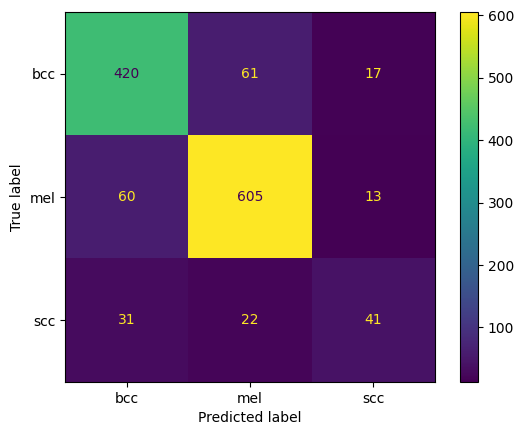

In [9]:
# confusion matrix
# cm = confusion_matrix(y_test, y_test_predicted)

# {'bcc': 0 (498), 'mel': 1 (678), 'scc': 2 (94)}
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

# With local color features

In [4]:
train_df_1 = pd.read_feather("../data/three_class/train_all_feat.f")
train_df_2 = pd.read_feather("../data/three_class/train_color_local_feat.f")
val_df_1 = pd.read_feather("../data/three_class/val_all_feat.f")
val_df_2 = pd.read_feather("../data/three_class/val_color_local_feat.f")


print(f'train shape: {train_df_1.shape}, val shape: {val_df_1.shape}')
print(f'train color: {train_df_2.shape}, val color: {val_df_2.shape}')

train shape: (5082, 144), val shape: (1270, 144)
train color: (5082, 61), val color: (1270, 61)


In [5]:
train_df = pd.concat([train_df_2.iloc[:,:60], train_df_1], axis=1)
val_df = pd.concat([val_df_2.iloc[:, :60], val_df_1], axis=1)

# move lbp features at the beginning
train_df = train_df[ [ col for col in train_df.columns if 'lbp' in col ] + [ col for col in train_df.columns if 'lbp' not in col ] ]
val_df = val_df[ [ col for col in val_df.columns if 'lbp' in col ] + [ col for col in val_df.columns if 'lbp' not in col ] ]

train_shape = train_df.shape
val_shape = val_df.shape

print(f'train shape: {train_shape}, val shape: {val_shape}')
print(train_df.label.value_counts())
print(val_df.label.value_counts())

train shape: (5082, 204), val shape: (1270, 204)
mel    2713
bcc    1993
scc     376
Name: label, dtype: int64
mel    678
bcc    498
scc     94
Name: label, dtype: int64


## Resampling

### Up-sampling minority class

In [8]:
train_bcc = train_df.loc[train_df.label == 'bcc']
train_mel = train_df.loc[train_df.label == 'mel']
train_scc = train_df.loc[train_df.label == 'scc']
train_scc_resamp = resample(train_scc, replace=True, n_samples=1993, random_state=123) 
train_df = pd.concat([train_bcc, train_mel, train_scc_resamp])

train_shape = train_df.shape
val_shape = val_df.shape
print(train_df.label.value_counts())
print(f'train shape: {train_shape}', f'val shape: {val_shape}')

mel    2713
bcc    1993
scc    1993
Name: label, dtype: int64
train shape: (6699, 204) val shape: (1270, 204)


X_train: (6699, 203), y_train: (6699,), X_test: (1270, 203), y_test: (1270,)

### Down-sampling mayority class

In [6]:
train_bcc = train_df.loc[train_df.label == 'bcc']
train_mel = train_df.loc[train_df.label == 'mel']
train_scc = train_df.loc[train_df.label == 'scc']
train_mel_resamp = resample(train_mel, replace=False, n_samples=1993, random_state=123) 
train_df = pd.concat([train_bcc, train_mel_resamp, train_scc])

train_shape = train_df.shape
val_shape = val_df.shape
print(train_df.label.value_counts())
print(f'train shape: {train_shape}', f'val shape: {val_shape}')

bcc    1993
mel    1993
scc     376
Name: label, dtype: int64
train shape: (4362, 204) val shape: (1270, 204)


### Up-sample and Down-sample

In [6]:
train_bcc = train_df.loc[train_df.label == 'bcc']
train_mel = train_df.loc[train_df.label == 'mel']
train_scc = train_df.loc[train_df.label == 'scc']

train_mel_resamp = resample(train_mel, replace=False, n_samples=1993, random_state=123) 
train_scc_resamp = resample(train_scc, replace=True, n_samples=1993, random_state=123) 
train_df = pd.concat([train_bcc, train_mel_resamp, train_scc_resamp])

train_shape = train_df.shape
val_shape = val_df.shape
print(train_df.label.value_counts())
print(f'train shape: {train_shape}', f'val shape: {val_shape}')


bcc    1993
mel    1993
scc    1993
Name: label, dtype: int64
train shape: (5979, 204) val shape: (1270, 204)


In [7]:
train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
print(f'final class balance [TRAIN]: {np.unique(y_train, return_counts=True)}', f'[VAL]: {np.unique(y_test, return_counts=True)}')

X_train: (5979, 203), y_train: (5979,), X_test: (1270, 203), y_test: (1270,)
final class balance [TRAIN]: (array([0, 1, 2]), array([1993, 1993, 1993])) [VAL]: (array([0, 1, 2]), array([498, 678,  94]))


### Other sampling techniques

In [5]:
train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
print(f'final class balance [TRAIN]: {np.unique(y_train, return_counts=True)}', f'[VAL]: {np.unique(y_test, return_counts=True)}')

X_train: (5082, 203), y_train: (5082,), X_test: (1270, 203), y_test: (1270,)
final class balance [TRAIN]: (array([0, 1, 2]), array([1993, 2713,  376])) [VAL]: (array([0, 1, 2]), array([498, 678,  94]))


In [6]:
# # std SMOTE
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)
# # (array([0, 1, 2]), array([2713, 2713, 2713]))

# Sampling strategy
over = SMOTE(sampling_strategy={2: 500}, random_state=42)
under = RandomUnderSampler(sampling_strategy={1: 1200, 0: 1000}, random_state=123)
steps = [('o', over), ('u', under)]
pipeline = impipe(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

print(np.unique(y_train, return_counts=True))

# # ADASYN
# # Sampling strategy
# over = ADASYN(sampling_strategy={2: 600})
# under = RandomUnderSampler(sampling_strategy={0: 1200, 1: 1000})
# steps = [('o', over), ('u', under)]
# pipe = impipe(steps=steps)
# # transform the dataset
# X_train, y_train = pipe.fit_resample(X_train, y_train)

# print(np.unique(y_train, return_counts=True))

INFO:root:sklearn.neighbors.NearestNeighbors.fit: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.kneighbors: running accelerated version on CPU


(array([0, 1, 2]), array([1000, 1200,  500]))


In [8]:
# Using kappa scoring function
# def kappa_scoring(y_true, y_pred):
#     return cohen_kappa_score(y_true, y_pred)

kappa_scoring = make_scorer(cohen_kappa_score)

## Classification

### Classification - SVC

In [9]:
classifier = svm.SVC(class_weight='balanced', probability=True)
C_range = np.logspace(-2, 1, 3)
gamma_range = np.logspace(-9, 3, 3)
# param_grid = dict(gamma=gamma_range, C=C_range)
param_grid = {'classifier__C': C_range,
                'classifier__gamma': gamma_range,
              'classifier__kernel': ['linear', 'poly', 'rbf']} # ['linear', 'poly', 'rbf']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
grid_search = GridSearchCV(pipe, param_grid, cv=cv, refit = True, verbose = 1, scoring=kappa_scoring)
grid_search.fit(X_train, y_train)

print("TRAIN- The best parameters are %s with an kappa-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Fitting 10 folds for each of 27 candidates, totalling 270 fits


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated versi

TRAIN- The best parameters are {'classifier__C': 10.0, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'} with an kappa-score of 0.6294


In [14]:
y_train_predicted = grid_search.predict(X_train)
y_train_pred_prob = grid_search.predict_proba(X_train)
y_test_predicted =  grid_search.predict(X_test)
y_test_pred_prob = grid_search.predict_proba(X_test)
auroc_train = roc_auc_score(y_train, y_train_pred_prob, multi_class='ovr', average='weighted')
auroc_test = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr', average='weighted')
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_train, y_train_predicted,)}', f'AUROC: {auroc_train}', f'Kappa: {cohen_kappa_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_test, y_test_predicted)}', f'AUROC: {auroc_test}', f'Kappa: {cohen_kappa_score(y_test, y_test_predicted)}')

INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn


F1 Score of train data: 0.8212 Acc: 0.7807777777777778 AUROC: 0.9250227061464316 Kappa: 0.71809951761052
F1 Score of test data: 0.7848 Acc: 0.6704244959502859 AUROC: 0.9047348982088924 Kappa: 0.6116029148689888


INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU


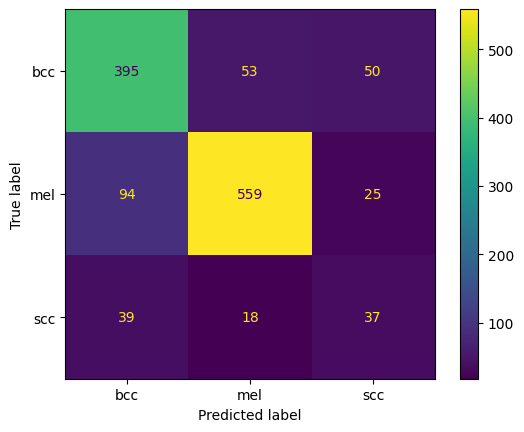

In [11]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

In [8]:
print('train',np.unique(y_train, return_counts=True))
print('val', np.unique(y_test, return_counts=True))

train (array([0, 1, 2]), array([1000, 1200,  500]))
val (array([0, 1, 2]), array([498, 678,  94]))


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU


F1 Score of train data: 0.8171 Acc: 0.7700555555555555 AUROC: 0.9239859675183204 Kappa: 0.7134011499336577
F1 Score of test data: 0.7989 Acc: 0.6874324638036234 AUROC: 0.9051839400628865 Kappa: 0.6375171361947288


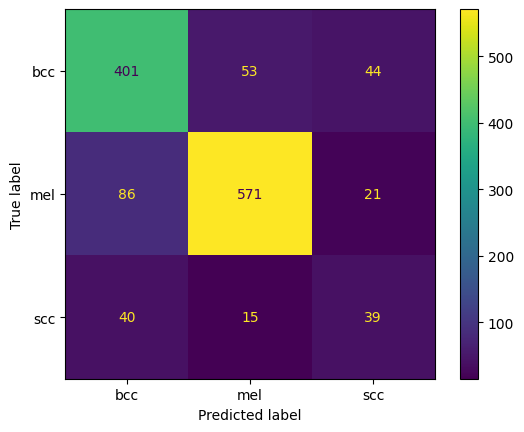

In [10]:
classifier = svm.SVC(class_weight='balanced', probability=True, C=10.0, gamma=0.001, kernel='rbf')
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# classifier.fit(X_train, y_train)
# X_test = scaler.transform(X_test)

scaler = TextureScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
classifier.fit(X_train, y_train)
X_test = scaler.transform(X_test)

# pipe_final = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
# pipe_final.fit(X_train, y_train)
y_train_predicted = classifier.predict(X_train)
y_train_pred_prob = classifier.predict_proba(X_train)
y_test_predicted =  classifier.predict(X_test)
y_test_pred_prob = classifier.predict_proba(X_test)
auroc_train = roc_auc_score(y_train, y_train_pred_prob, multi_class='ovr', average='weighted')
auroc_test = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr', average='weighted')
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_train, y_train_predicted,)}', f'AUROC: {auroc_train}', f'Kappa: {cohen_kappa_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_test, y_test_predicted)}', f'AUROC: {auroc_test}', f'Kappa: {cohen_kappa_score(y_test, y_test_predicted)}')

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

### Classification - RF

In [5]:
train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
print(f'final class balance [TRAIN]: {np.unique(y_train, return_counts=True)}', f'[VAL]: {np.unique(y_test, return_counts=True)}')

X_train: (5082, 203), y_train: (5082,), X_test: (1270, 203), y_test: (1270,)
final class balance [TRAIN]: (array([0, 1, 2]), array([1993, 2713,  376])) [VAL]: (array([0, 1, 2]), array([498, 678,  94]))


In [6]:
# Sampling strategy
over = SVMSMOTE(sampling_strategy={2: 1000}, random_state=123)
under = RandomUnderSampler(sampling_strategy={1: 1000, 0: 1000})
steps = [('o', over), ('u', under)]
pipeline = impipe(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

print(np.unique(y_train, return_counts=True))

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.fit: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.kneighbors: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.kneighbors: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.fit: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.kneighbors: running accelerated version on CPU


(array([0, 1, 2]), array([1000, 1000,  586]))


In [10]:
# Using kappa scoring function
# def kappa_scoring(y_true, y_pred):
#     return cohen_kappa_score(y_true, y_pred)

kappa_scoring = make_scorer(cohen_kappa_score)

In [12]:
classifier =  RandomForestClassifier(class_weight='balanced') #svm.SVC(class_weight='balanced', probability=True), max_features=X_train.shape[1]
# classifier = ExtraTreesClassifier(class_weight='balanced')
estimators_range = [100, 200, 300]
depth_range = [50, 100, 200]
param_grid = {'classifier__n_estimators': estimators_range,
                'classifier__max_depth': depth_range}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, refit=True, verbose=1, scoring=kappa_scoring)
grid_search.fit(X_train, y_train)

print("TRAIN- The best parameters are %s with an Kappa-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))

INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU


Fitting 10 folds for each of 9 candidates, totalling 90 fits


INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated v

TRAIN- The best parameters are {'classifier__max_depth': 100, 'classifier__n_estimators': 300} with an Kappa-score of 0.6772


In [13]:
y_train_predicted = grid_search.predict(X_train)
y_train_pred_prob = grid_search.predict_proba(X_train)
y_test_predicted =  grid_search.predict(X_test)
y_test_pred_prob = grid_search.predict_proba(X_test)
auroc_train = roc_auc_score(y_train, y_train_pred_prob, multi_class='ovr', average='weighted')
auroc_test = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr', average='weighted')
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_train, y_train_predicted,)}', f'AUROC: {auroc_train}', f'Kappa: {cohen_kappa_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_test, y_test_predicted)}', f'AUROC: {auroc_test}', f'Kappa: {cohen_kappa_score(y_test, y_test_predicted)}')

INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn


F1 Score of train data: 1.0000 Acc: 1.0 AUROC: 1.0 Kappa: 1.0
F1 Score of test data: 0.7741 Acc: 0.7170505911173723 AUROC: 0.9064822531117184 Kappa: 0.5880368496172311


INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU


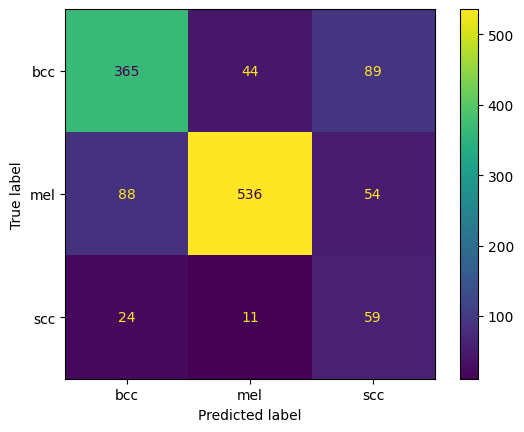

In [14]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

In [ ]:
# Features importances
feature_importances = grid_search.best_estimator_._final_estimator.feature_importances_
cfe = FeaturesExtraction(levels=['global','local'])
fimp_df = pd.DataFrame(data=[feature_importances], columns=cfe.features_names).transpose()
# fimp_df
fimp_df.sort_values(0,axis=0,inplace=True, ascending=False)
fimp_df.head(50)

### Gradient-boosting

In [7]:
kappa_scoring = make_scorer(cohen_kappa_score)
classifier = GradientBoostingClassifier()
estimators_range = [300]
depth_range = [100, 200]
param_grid = {'classifier__n_estimators': estimators_range,
                'classifier__max_depth': depth_range}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, refit=True, verbose=3, scoring=kappa_scoring, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("TRAIN- The best parameters are %s with an Kappa-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 5/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.603 total time= 7.3min
[CV 1/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.474 total time= 7.4min
[CV 8/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.501 total time= 7.4min
[CV 6/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.542 total time= 7.5min
[CV 3/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.565 total time= 7.6min
[CV 2/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.550 total time= 7.8min
[CV 7/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.531 total time= 8.0min
[CV 4/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.583 total time= 8.0min
[CV 9/10] END classifier__max_depth=100, classifier__n_estimators=300;, score=0.575 total time= 7.2min
[CV 1/10] EN

In [10]:
print("TRAIN- The best parameters are %s with an Kappa-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))

TRAIN- The best parameters are {'classifier__max_depth': 200, 'classifier__n_estimators': 300} with an Kappa-score of 0.5511


In [8]:
y_train_predicted = grid_search.predict(X_train)
y_train_pred_prob = grid_search.predict_proba(X_train)
y_test_predicted =  grid_search.predict(X_test)
y_test_pred_prob = grid_search.predict_proba(X_test)
auroc_train = roc_auc_score(y_train, y_train_pred_prob, multi_class='ovr', average='weighted')
auroc_test = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr', average='weighted')
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_train, y_train_predicted,)}', f'AUROC: {auroc_train}', f'Kappa: {cohen_kappa_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_test, y_test_predicted)}', f'AUROC: {auroc_test}', f'Kappa: {cohen_kappa_score(y_test, y_test_predicted)}')

INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn


F1 Score of train data: 1.0000 Acc: 1.0 AUROC: 1.0 Kappa: 1.0
F1 Score of test data: 0.7348 Acc: 0.6194104227113689 AUROC: 0.8571064672446632 Kappa: 0.523537170782338


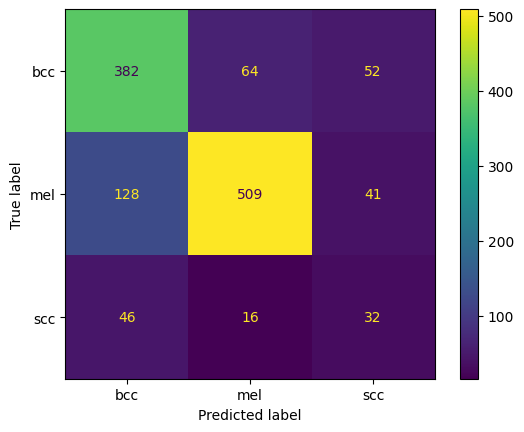

In [9]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

### Adaboost

In [5]:
# train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
# val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

# df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
# df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# # df_val

# X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
# X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

# print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
# print(f'final class balance [TRAIN]: {np.unique(y_train, return_counts=True)}', f'[VAL]: {np.unique(y_test, return_counts=True)}')

X_train: (5082, 203), y_train: (5082,), X_test: (1270, 203), y_test: (1270,)
final class balance [TRAIN]: (array([0, 1, 2]), array([1993, 2713,  376])) [VAL]: (array([0, 1, 2]), array([498, 678,  94]))


In [7]:
print('train',np.unique(y_train, return_counts=True))
print('val', np.unique(y_test, return_counts=True))

train (array([0, 1, 2]), array([1000, 1200,  500]))
val (array([0, 1, 2]), array([498, 678,  94]))


In [8]:
kappa_scoring = make_scorer(cohen_kappa_score)
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), learning_rate=1)# svm.SVC(class_weight='balanced', probability=True)
estimators_range = [500, 700, 900]
param_grid = {'classifier__n_estimators': estimators_range}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
grid_search = GridSearchCV(pipe, param_grid, cv=cv, refit = True, verbose = 3, scoring=kappa_scoring, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("TRAIN- The best parameters are %s with an kappa-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 3/10] END .....classifier__n_estimators=500;, score=0.605 total time= 2.2min
[CV 1/10] END .....classifier__n_estimators=500;, score=0.619 total time= 2.2min
[CV 5/10] END .....classifier__n_estimators=500;, score=0.616 total time= 2.2min
[CV 7/10] END .....classifier__n_estimators=500;, score=0.537 total time= 2.2min
[CV 4/10] END .....classifier__n_estimators=500;, score=0.555 total time= 2.2min
[CV 2/10] END .....classifier__n_estimators=500;, score=0.581 total time= 2.2min
[CV 6/10] END .....classifier__n_estimators=500;, score=0.619 total time= 2.2min
[CV 8/10] END .....classifier__n_estimators=500;, score=0.562 total time= 2.3min
[CV 10/10] END ....classifier__n_estimators=500;, score=0.543 total time= 2.4min
[CV 9/10] END .....classifier__n_estimators=500;, score=0.583 total time= 2.4min
[CV 3/10] END .....classifier__n_estimators=700;, score=0.615 total time= 3.2min
[CV 1/10] END .....classifier__n_estimators=700;

INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn
INFO:root:sklearn.metrics.roc_auc_score: fallback to original Scikit-learn


F1 Score of train data: 0.9473 Acc: 0.9358333333333334 AUROC: 0.9647675770779693 Kappa: 0.9164305331531453
F1 Score of test data: 0.7841 Acc: 0.6859376248482287 AUROC: 0.8764769599844742 Kappa: 0.6092036717605556


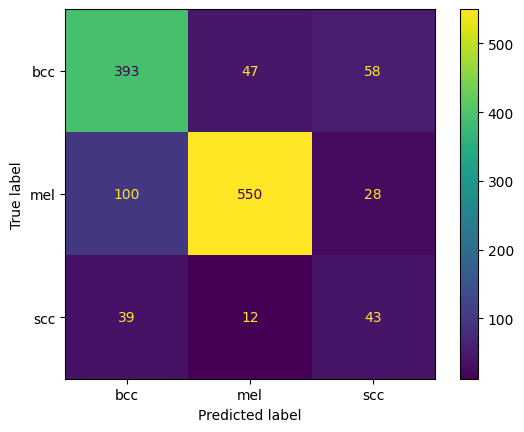

In [9]:
y_train_predicted = grid_search.predict(X_train)
y_train_pred_prob = grid_search.predict_proba(X_train)
y_test_predicted =  grid_search.predict(X_test)
y_test_pred_prob = grid_search.predict_proba(X_test)
auroc_train = roc_auc_score(y_train, y_train_pred_prob, multi_class='ovr', average='weighted')
auroc_test = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr', average='weighted')
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_train, y_train_predicted,)}', f'AUROC: {auroc_train}', f'Kappa: {cohen_kappa_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_test, y_test_predicted)}', f'AUROC: {auroc_test}', f'Kappa: {cohen_kappa_score(y_test, y_test_predicted)}')

ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

### XGBoost

In [5]:
xgb.set_config(verbosity=1)

In [6]:
# train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
# val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

# df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
# df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# # df_val

# X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
# X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

# print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
# print(f'final class balance [TRAIN]: {np.unique(y_train, return_counts=True)}', f'[VAL]: {np.unique(y_test, return_counts=True)}')

X_train: (5082, 203), y_train: (5082,), X_test: (1270, 203), y_test: (1270,)
final class balance [TRAIN]: (array([0, 1, 2]), array([1993, 2713,  376])) [VAL]: (array([0, 1, 2]), array([498, 678,  94]))


In [14]:
print('train',np.unique(y_train, return_counts=True))
print('val', np.unique(y_test, return_counts=True))

train (array([0, 1, 2]), array([1000, 1200,  500]))
val (array([0, 1, 2]), array([498, 678,  94]))


In [15]:

classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

classifier = XGBClassifier(objective='multi:softprob', max_depth=3, n_jobs=-1) # objective=multi:softprob,

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
classifier.fit(X_train, y_train, sample_weight=classes_weights) #  sample_weight=classes_weights
X_test = scaler.transform(X_test)

# scaler = TextureScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# classifier.fit(X_train, y_train, sample_weight=classes_weights)
# X_test = scaler.transform(X_test)

F1 Score of train data: 0.9878 Acc: 0.9902222222222222 AUROC: 0.9994828626130587 Kappa: 0.9806699353495032
F1 Score of test data: 0.7940 Acc: 0.7162532008407698 AUROC: 0.9179964417763992 Kappa: 0.6249785241817714


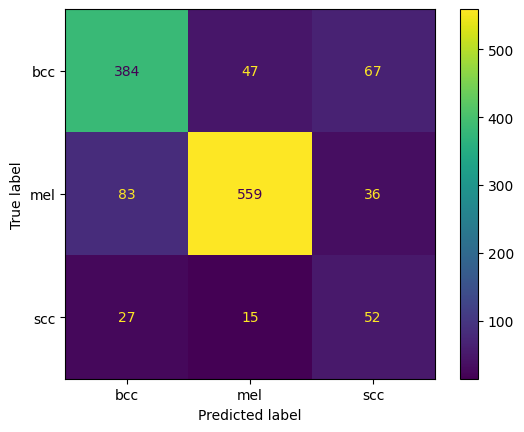

In [16]:
y_train_predicted = classifier.predict(X_train)
y_train_pred_prob = classifier.predict_proba(X_train)
y_test_predicted =  classifier.predict(X_test)
y_test_pred_prob = classifier.predict_proba(X_test)
auroc_train = roc_auc_score(y_train, y_train_pred_prob, multi_class='ovr', average='weighted')
auroc_test = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr', average='weighted')
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_train, y_train_predicted,)}', f'AUROC: {auroc_train}', f'Kappa: {cohen_kappa_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {balanced_accuracy_score(y_test, y_test_predicted)}', f'AUROC: {auroc_test}', f'Kappa: {cohen_kappa_score(y_test, y_test_predicted)}')

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

## Ensemble methods

In [6]:
# # data preparation

train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
print('bcc: 0, mel: 1, scc: 2')
print(f'final class balance [TRAIN]: {np.unique(y_train, return_counts=True)}', f'[VAL]: {np.unique(y_test, return_counts=True)}')

X_train: (5082, 203), y_train: (5082,), X_test: (1270, 203), y_test: (1270,)
bcc: 0, mel: 1, scc: 2
final class balance [TRAIN]: (array([0, 1, 2]), array([1993, 2713,  376])) [VAL]: (array([0, 1, 2]), array([498, 678,  94]))


In [7]:

# RF Running on the go

# data preparation
train_df_1 = pd.read_feather("../data/three_class/train_all_feat.f")
train_df_2 = pd.read_feather("../data/three_class/train_color_local_feat.f")
val_df_1 = pd.read_feather("../data/three_class/val_all_feat.f")
val_df_2 = pd.read_feather("../data/three_class/val_color_local_feat.f")

train_df = pd.concat([train_df_2.iloc[:,:60], train_df_1], axis=1)
val_df = pd.concat([val_df_2.iloc[:, :60], val_df_1], axis=1)

# move lbp features at the beginning
train_df = train_df[ [ col for col in train_df.columns if 'lbp' in col ] + [ col for col in train_df.columns if 'lbp' not in col ] ]
val_df = val_df[ [ col for col in val_df.columns if 'lbp' in col ] + [ col for col in val_df.columns if 'lbp' not in col ] ]

train_shape = train_df.shape
val_shape = val_df.shape

train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

# training model
classifier =  RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=300, random_state=42)
pipe_clf4_rf = Pipeline([('scaler', StandardScaler()), ('classifier', classifier)])
# X_train = scaler.fit_transform(X_train)
pipe_clf4_rf.fit(X_train, y_train)

del train_df, val_df, train_shape, val_shape, X_train, y_train, X_test, y_test, classifier

train_df_1 = pd.read_feather("../data/three_class/train_all_feat.f")
train_df_2 = pd.read_feather("../data/three_class/train_color_local_feat.f")
val_df_1 = pd.read_feather("../data/three_class/val_all_feat.f")
val_df_2 = pd.read_feather("../data/three_class/val_color_local_feat.f")

train_df = pd.concat([train_df_2.iloc[:,:60], train_df_1], axis=1)
val_df = pd.concat([val_df_2.iloc[:, :60], val_df_1], axis=1)

# move lbp features at the beginning
train_df = train_df[ [ col for col in train_df.columns if 'lbp' in col ] + [ col for col in train_df.columns if 'lbp' not in col ] ]
val_df = val_df[ [ col for col in val_df.columns if 'lbp' in col ] + [ col for col in val_df.columns if 'lbp' not in col ] ]

train_shape = train_df.shape
val_shape = val_df.shape

train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

over = SMOTE(sampling_strategy={2: 500}, random_state=42)
under = RandomUnderSampler(sampling_strategy={1: 1200, 0: 1000}, random_state=123)
steps = [('o', over), ('u', under)]
smote_pipe = impipe(steps=steps)
# transform the dataset
X_train, y_train = smote_pipe.fit_resample(X_train, y_train)

classifier =  RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=300, random_state=42)
pipe_clf5_rf = Pipeline([('scaler', StandardScaler()), ('classifier', classifier)])
pipe_clf5_rf.fit(X_train, y_train)

del train_df, val_df, train_shape, val_shape, X_train, y_train, X_test, y_test, classifier

train_df_1 = pd.read_feather("../data/three_class/train_all_feat.f")
train_df_2 = pd.read_feather("../data/three_class/train_color_local_feat.f")
val_df_1 = pd.read_feather("../data/three_class/val_all_feat.f")
val_df_2 = pd.read_feather("../data/three_class/val_color_local_feat.f")

train_df = pd.concat([train_df_2.iloc[:,:60], train_df_1], axis=1)
val_df = pd.concat([val_df_2.iloc[:, :60], val_df_1], axis=1)

# move lbp features at the beginning
train_df = train_df[ [ col for col in train_df.columns if 'lbp' in col ] + [ col for col in train_df.columns if 'lbp' not in col ] ]
val_df = val_df[ [ col for col in val_df.columns if 'lbp' in col ] + [ col for col in val_df.columns if 'lbp' not in col ] ]

train_bcc = train_df.loc[train_df.label == 'bcc']
train_mel = train_df.loc[train_df.label == 'mel']
train_scc = train_df.loc[train_df.label == 'scc']

train_mel_resamp = resample(train_mel, replace=False, n_samples=1993, random_state=123) 
train_scc_resamp = resample(train_scc, replace=True, n_samples=1993, random_state=123) 
train_df = pd.concat([train_bcc, train_mel_resamp, train_scc_resamp])

train_shape = train_df.shape
val_shape = val_df.shape

train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

classifier =  ExtraTreesClassifier(class_weight='balanced', max_depth=50, n_estimators=200, random_state=42)
pipe_clf6_ert = Pipeline([('scaler', StandardScaler()), ('classifier', classifier)])
pipe_clf6_ert.fit(X_train, y_train)


INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.fit: running accelerated version on CPU
INFO:root:sklearn.neighbors.NearestNeighbors.kneighbors: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.fit: running accelerated version on CPU


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=50,
                                      n_estimators=200, random_state=42))])

In [8]:
clf1 = pd.read_pickle('../data/three_class/models/clf1_svc.pkl') # 1, CM8, BCC/MEL
clf1_scaler = pd.read_pickle('../data/three_class/models/clf1_scaler.pkl') # Scaler
pipe_clf1_svc = Pipeline([('scaler', clf1_scaler), ('classifier', clf1)])

clf2 = pd.read_pickle('../data/three_class/models/clf2_svc.pkl') # 2, CM16, BCC/MEL/SCC
clf2_scaler = pd.read_pickle('../data/three_class/models/clf2_scaler.pkl') # Scaler
pipe_clf2_svc = Pipeline([('scaler', clf2_scaler), ('classifier', clf2)])

clf3 = pd.read_pickle('../data/three_class/models/clf3_xgb.pkl') # 3, CM31, BCC/MEL
clf3_scaler = pd.read_pickle('../data/three_class/models/clf3_scaler.pkl') # Scaler
pipe_clf3_xgb = Pipeline([('scaler', clf3_scaler), ('classifier', clf3)])



In [10]:
# majority voting
clf_dict_1 = {'clf1_svc': pipe_clf1_svc, 'clf2_svc': pipe_clf2_svc, 'clf3_xgb': pipe_clf3_xgb, 'clf4_rf': pipe_clf4_rf, 'clf5_rf': pipe_clf5_rf, 'clf6_ert': pipe_clf6_ert}
clf_dict_2 = {'clf1_svc': pipe_clf1_svc, 'clf3_xgb': pipe_clf3_xgb, 'clf4_rf': pipe_clf4_rf, 'clf5_rf': pipe_clf5_rf, 'clf6_ert': pipe_clf6_ert}
clf_dict_3 = {'clf1_svc': pipe_clf1_svc, 'clf4_rf': pipe_clf4_rf, 'clf5_rf': pipe_clf5_rf}
clf_dict_4 = {'clf1_svc': pipe_clf1_svc, 'clf4_rf': pipe_clf4_rf, 'clf5_rf': pipe_clf5_rf}

In [15]:
results = majority_voting_ensemble(clf_dict_3, X_test, y_test, [1, 4, 1])
results

INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU


{'hard': {'kappa': 0.5803014392488727,
  'cm': array([[357,  44,  97],
         [ 82, 525,  71],
         [ 18,   9,  67]])},
 'soft': {'kappa': 0.6757184081066496,
  'cm': array([[427,  48,  23],
         [ 95, 572,  11],
         [ 37,  15,  42]])},
 'soft_w': {'kappa': 0.6183686461086145,
  'cm': array([[381,  42,  75],
         [ 76, 539,  63],
         [ 20,  11,  63]])}}

In [40]:
results_val = np.zeros((y_test.shape[0],len(clf_dict)))
results_train = np.zeros((y_train.shape[0],len(clf_dict)))
plot_results = {}
for i, clf in enumerate(clf_dict.values()): 
    train_val = {}
    results_val[:,i] = clf.predict(X_test)
    # train_val['val'] = cohen_kappa_score(y_test, results_val[:,i])
    results_train[:,i] = clf.predict(X_train)    
    # train_val['train'] = cohen_kappa_score(y_train, results_train[:,i])
    plot_results[list(clf_dict.keys())[i]] = cohen_kappa_score(y_test, results_val[:,i])

y_test_predicted, _ = np.uint16(stats.mode(results_val, axis=1, keepdims=False))
y_train_predicted, _ = np.uint16(stats.mode(results_train, axis=1, keepdims=False))

print(f'Train kappa: {cohen_kappa_score(y_train, y_train_predicted)}', f'Val kappa: {cohen_kappa_score(y_test, y_test_predicted)}')
print(confusion_matrix(y_test, y_test_predicted))
plot_results['eclf_h'] = cohen_kappa_score(y_test, y_test_predicted)
all_results['hard'] = plot_results

INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict: running accelerated version on CPU


Train kappa: 0.9846964375313597 Val kappa: 0.677399776106318
[[441  43  14]
 [ 96 571  11]
 [ 44  18  32]]


In [12]:
# soft prediction
results_val = np.zeros((y_test.shape[0],3,len(clf_dict)))
results_train = np.zeros((y_train.shape[0],3,len(clf_dict)))
plot_results = {}
for i, clf in enumerate(clf_dict.values()): # pipe_clf2_svc
    results_val[:,:,i] = clf.predict_proba(X_test)
    results_train[:,:,i] = clf.predict_proba(X_train)
    plot_results[list(clf_dict.keys())[i]] = cohen_kappa_score(y_test, clf.predict(X_test))
    
y_test_predicted = np.argmax(np.mean(results_val, axis=2), axis=1)
y_train_predicted = np.argmax(np.mean(results_train, axis=2), axis=1)

print(f'Train kappa: {cohen_kappa_score(y_train, y_train_predicted)}', f'Val kappa: {cohen_kappa_score(y_test, y_test_predicted)}')
print(confusion_matrix(y_test, y_test_predicted))

plot_results['eclf_s'] = cohen_kappa_score(y_test, y_test_predicted)
all_results['soft'] = plot_results

INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomFor

Train kappa: 0.9992473657802308 Val kappa: 0.6875297628496142
[[428  56  14]
 [ 82 591   5]
 [ 41  19  34]]


In [14]:
# soft weighted prediction
weights = np.asarray([1, 1, 1, 4, 1, 1])
results_val = np.zeros((y_test.shape[0],3,len(clf_dict)))
results_train = np.zeros((y_train.shape[0],3,len(clf_dict)))
plot_results = {}

for i, clf in enumerate(clf_dict.values()): # pipe_clf2_svc
    results_val[:,:,i] = clf.predict_proba(X_test)
    results_train[:,:,i] = clf.predict_proba(X_train)
    plot_results[list(clf_dict.keys())[i]] = cohen_kappa_score(y_test, clf.predict(X_test))
    
results_val = results_val*np.tile(np.array(weights), (results_val.shape[0], 1))[:, np.newaxis]
results_train = results_train*np.tile(np.array(weights), (results_train.shape[0], 1))[:, np.newaxis]
y_test_predicted = np.argmax(np.mean(results_val, axis=2), axis=1)
y_train_predicted = np.argmax(np.mean(results_train, axis=2), axis=1)

print(f'Train kappa: {cohen_kappa_score(y_train, y_train_predicted)}', f'Val kappa: {cohen_kappa_score(y_test, y_test_predicted)}')
print(confusion_matrix(y_test, y_test_predicted))

plot_results['eclf_sw'] = cohen_kappa_score(y_test, y_test_predicted)
all_results['soft_w'] = plot_results

INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomForestClassifier.predict_proba: running accelerated version on CPU
INFO:root:sklearn.ensemble.RandomFor

Train kappa: 0.9994982438534872 Val kappa: 0.685644960063224
[[421  51  26]
 [ 79 580  19]
 [ 33  15  46]]


In [20]:
all_results['hard'].keys()

dict_keys(['clf1_svc', 'clf2_svc', 'clf3_xgb', 'clf4_rf', 'clf5_rf', 'clf6_ert', 'eclf_h'])

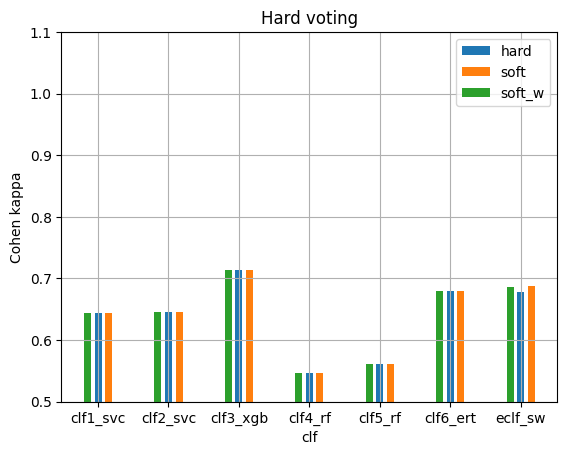

In [25]:
hard = [all_results['hard'][clf] for clf in all_results['hard'].keys()]
soft = [all_results['soft'][clf]for clf in all_results['soft'].keys()]
soft_w = [all_results['soft_w'][clf]for clf in all_results['soft_w'].keys()]

X_axis = np.arange(len(all_results['hard'].keys()))
plt.bar(X_axis , hard, 0.1, label = 'hard')
plt.bar(X_axis + 0.15, soft, 0.1, label = 'soft' )
plt.bar(X_axis - 0.15, soft_w, 0.1, label = 'soft_w')
  
plt.xticks(X_axis, plot_results.keys())
plt.xlabel("clf")
plt.ylabel("Cohen kappa")
plt.ylim([0.5, 1.1])
plt.title("Hard voting")
plt.legend()
plt.grid()
plt.show()

In [32]:
(results_val*np.tile(np.array(weights), (results_val.shape[0], 1))[:, np.newaxis])[0,:,:]

array([[0.2465092 , 0.32867893, 0.07172033, 0.09032778],
       [0.00721128, 0.00961504, 0.02778673, 0.03338734],
       [0.04627952, 0.06170603, 0.20049296, 0.1762849 ]])

In [33]:
results_val[0,0,:]

array([0.82169734, 0.82169734, 0.23906778, 0.30109259])

In [34]:
np.tile(np.array(weights), (3, 1))

array([[0.3, 0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3, 0.3],
       [0.3, 0.4, 0.3, 0.3]])

In [9]:

classifier = pd.read_pickle('../data/three_class/models/clf4_rf.pkl')
scaler = pd.read_pickle('../data/three_class/models/clf4_scaler.pkl')
# pipeline = load('pipe_rf.joblib')
# pipeline = load('pipe_rf_intel.joblib')

# classifier = svm.SVC(class_weight='balanced', probability=True, C=10, gamma=0.001, kernel='rbf')
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

# classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
# classifier = XGBClassifier(objective='multi:softprob', n_jobs=-1) # objective=multi:softprob,
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# classifier.fit(X_train, y_train, sample_weight=classes_weights) #  sample_weight=classes_weights
# X_test = scaler.transform(X_test)

# classifier =  RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=300, random_state=42)
# pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', classifier)])
# # X_train = scaler.fit_transform(X_train)
# pipeline.fit(X_train, y_train)
# # X_test = scaler.transform(X_test)

classifier =  ExtraTreesClassifier(class_weight='balanced', max_depth=50, n_estimators=200, random_state=42)
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', classifier)])
pipeline.fit(X_train, y_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=50,
                                      n_estimators=200, random_state=42))])

Train kappa: 1.0 Val kappa: 0.6797237875585187


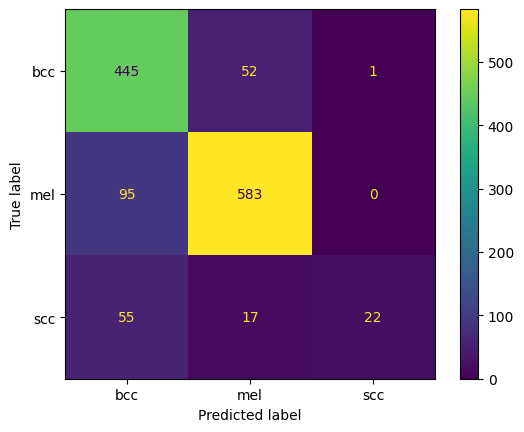

In [10]:
y_train_predicted = pipeline.predict(X_train)
y_test_predicted =  pipeline.predict(X_test)
print(f'Train kappa: {cohen_kappa_score(y_train, y_train_predicted)}', f'Val kappa: {cohen_kappa_score(y_test, y_test_predicted)}')

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

In [ ]:
# pd.to_pickle(scaler, '../data/three_class/models/clf4_scaler.pkl')
# dump(pipeline, 'pipe_rf_intel.joblib') 
